In [1]:
import cv2 as cv
import numpy as np
img = np.array(cv.imread('./odciski/p42.bmp',0))

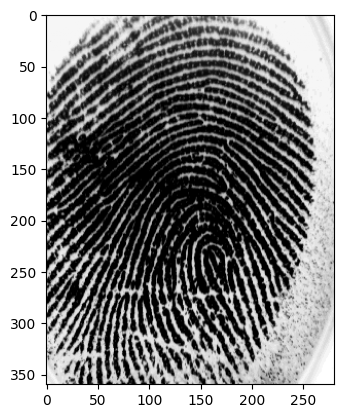

In [2]:
from funcs import *
import matplotlib.pyplot as plt
normalized = normalize_image(img)
plt.imshow(normalized, cmap='gray')


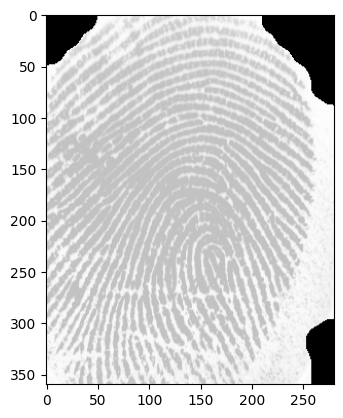

In [3]:
masked, normalized_2, mask = segment_and_normalize(normalized) 
plt.imshow(masked, cmap='gray')
# plt.show()
# plt.imshow(normalized_2, cmap='gray')
# plt.show()
# plt.imshow(mask, cmap='gray')


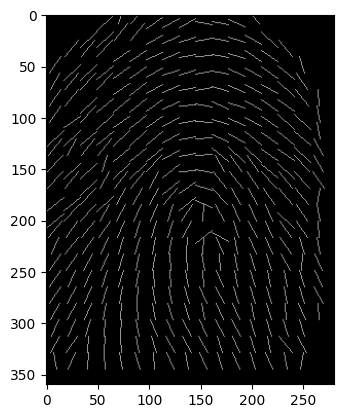

In [4]:
orient = estimate_orientation_map(normalized)
orient_render = render_orientation_lines(masked, mask, orient)
plt.imshow(orient_render, cmap='gray')

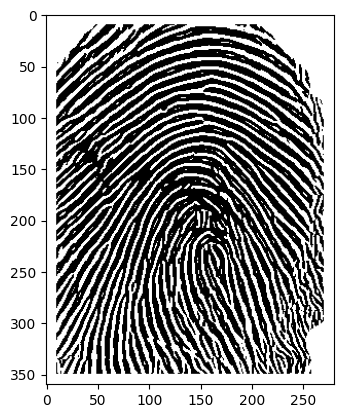

In [5]:
ridge_freq = ridge_frequency(normalized_2, mask, orient)
gabor = gabor_filter(normalized_2, orient, ridge_freq)
plt.imshow(gabor, cmap='gray')

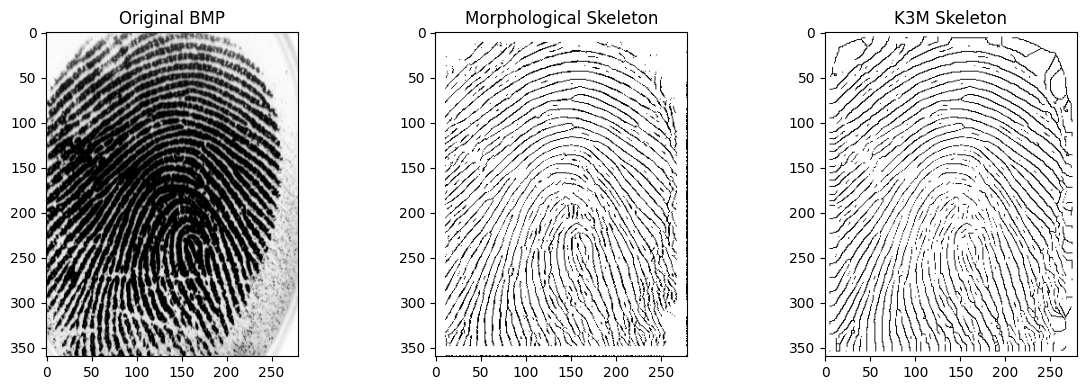

In [6]:
def morphological_skeleton(image):
    img = image.copy()
    skel = np.zeros(img.shape, np.uint8)
    element = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))

    while True:
        open_img = cv.morphologyEx(img, cv.MORPH_OPEN, element)
        temp = cv.subtract(img, open_img)
        eroded = cv.erode(img, element)
        skel = cv.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv.countNonZero(img) == 0:
            break

    return skel

# --- K3M Skeletonization ---
def neighbours(x, y, image):
    return [image[x-1, y], image[x-1, y+1], image[x, y+1], image[x+1, y+1],
            image[x+1, y], image[x+1, y-1], image[x, y-1], image[x-1, y-1]]

def transitions(neighbors):
    n = neighbors + neighbors[0:1]
    return sum((n[i] == 0 and n[i+1] == 1) for i in range(8))

def k3m_thinning(img):
    img = (img > 0).astype(np.uint8)
    img = np.pad(img, ((1,1),(1,1)), 'constant', constant_values=0)
    
    changed = True
    while changed:
        changed = False
        for pattern in [
            [0, 2, 4, 6],
            [0], [2], [4], [6],
        ]:
            to_remove = []
            for x in range(1, img.shape[0] - 1):
                for y in range(1, img.shape[1] - 1):
                    if img[x, y] == 1:
                        nb = neighbours(x, y, img)
                        if 2 <= sum(nb) <= 6 and transitions(nb) == 1:
                            if any(nb[i] == 0 for i in pattern):
                                to_remove.append((x, y))
            if to_remove:
                changed = True
                for x, y in to_remove:
                    img[x, y] = 0
    return (img[1:-1, 1:-1] * 255).astype(np.uint8)

# def preprocess_fingerprint(binary_img):
#     kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
#     closed = cv.morphologyEx(binary_img, cv.MORPH_CLOSE, kernel)
#     smoothed = cv.medianBlur(closed, 3)
#     return smoothed

# processed = preprocess_fingerprint(gabor)

# Apply both methods
skeleton_morph = morphological_skeleton(gabor)
skeleton_k3m = k3m_thinning(gabor)

skeleton_k3m = cv.bitwise_not(skeleton_k3m)
skeleton_morph = cv.bitwise_not(skeleton_morph)

# Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original BMP")
plt.imshow(img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Morphological Skeleton")
plt.imshow(skeleton_morph, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("K3M Skeleton")
plt.imshow(skeleton_k3m, cmap='gray')

plt.tight_layout()
plt.show()


# revert black and white




In [7]:
minutiae = extract_minutiae(skeleton_k3m)


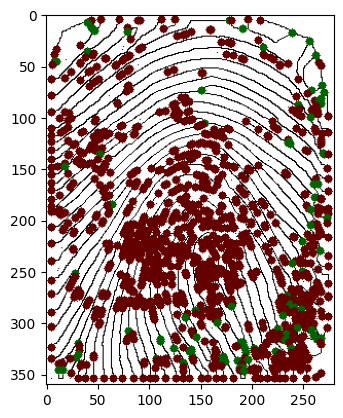

In [8]:
plt.imshow(minutiae)

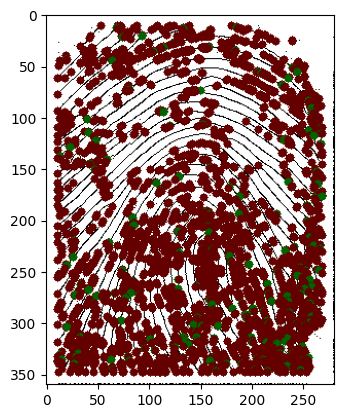

In [9]:
minutiae_morph = extract_minutiae(skeleton_morph)
plt.imshow(minutiae_morph)